# About this notebook  
- PyTorch resnext50_32x4d starter code  
- StratifiedKFold 5 folds  

If this notebook is helpful, feel free to upvote :)

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

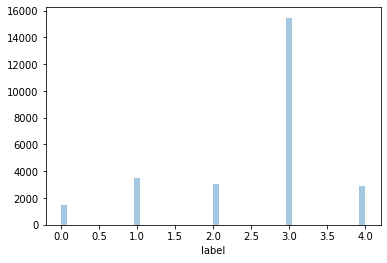

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = "resnext50_32x4d"
    size = 384  # 512 if ON_KAGGLE else 384
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = (
        "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    )
    epochs = 10
    # factor=0.2 # ReduceLROnPlateau
    # patience=4 # ReduceLROnPlateau
    # eps=1e-6 # ReduceLROnPlateau
    # T_max=10 # CosineAnnealingLR
    T_0 = 10  # CosineAnnealingWarmRestarts
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 24
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 22
    target_size = 5
    target_col = "label"
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/bitemperedlogloss/")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    Compose,
    Cutout,
    HorizontalFlip,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

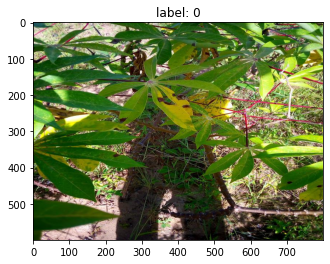

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

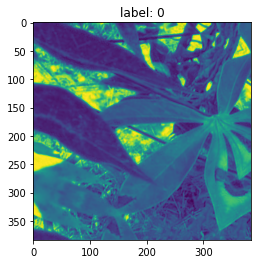

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# MODEL

In [15]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
model = CustomResNext(model_name=CFG.model_name, pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1431,  0.0153,  0.0244,  0.0381, -0.3684],
        [ 0.1256,  0.1112, -0.0494, -0.0359, -0.5083],
        [ 0.1774,  0.0931,  0.1443,  0.1434, -0.1211],
        [ 0.2822,  0.0414,  0.1201, -0.0730, -0.1520]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [17]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f}  "
                #'LR: {lr:.6f}  '
                .format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    # lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [19]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda"):
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [20]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [21]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/877] Data 0.522 (0.522) Elapsed 0m 4s (remain 59m 9s) Loss: 0.5014(0.5014) Grad: 2.0269  
Epoch: [1][100/877] Data 0.000 (0.005) Elapsed 2m 10s (remain 16m 42s) Loss: 0.2099(0.2630) Grad: 2.4945  
Epoch: [1][200/877] Data 0.000 (0.003) Elapsed 4m 16s (remain 14m 24s) Loss: 0.2746(0.2337) Grad: 2.6252  
Epoch: [1][300/877] Data 0.000 (0.002) Elapsed 6m 23s (remain 12m 13s) Loss: 0.1913(0.2153) Grad: 2.3768  
Epoch: [1][400/877] Data 0.000 (0.001) Elapsed 8m 29s (remain 10m 4s) Loss: 0.2140(0.2043) Grad: 2.4719  
Epoch: [1][500/877] Data 0.000 (0.001) Elapsed 10m 35s (remain 7m 57s) Loss: 0.2331(0.1993) Grad: 3.5517  
Epoch: [1][600/877] Data 0.000 (0.001) Elapsed 12m 42s (remain 5m 50s) Loss: 0.1729(0.1967) Grad: 2.4866  
Epoch: [1][700/877] Data 0.000 (0.001) Elapsed 14m 48s (remain 3m 43s) Loss: 0.2539(0.1928) Grad: 2.6344  
Epoch: [1][800/877] Data 0.000 (0.001) Elapsed 16m 54s (remain 1m 36s) Loss: 0.1644(0.1892) Grad: 1.7496  
Epoch: [1][876/877] Data 0.000 (0.001) Ela

Epoch 1 - avg_train_loss: 0.1860  avg_val_loss: 0.1552  time: 1185s
Epoch 1 - Accuracy: 0.8263097949886105
Epoch 1 - Save Best Score: 0.8263 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2311(0.1552) 
Epoch: [2][0/877] Data 0.485 (0.485) Elapsed 0m 1s (remain 25m 49s) Loss: 0.2041(0.2041) Grad: 1.8695  
Epoch: [2][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1170(0.1590) Grad: 1.2392  
Epoch: [2][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 16s) Loss: 0.2664(0.1542) Grad: 2.4339  
Epoch: [2][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1593(0.1557) Grad: 1.5074  
Epoch: [2][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 2s) Loss: 0.0737(0.1529) Grad: 2.1466  
Epoch: [2][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1675(0.1526) Grad: 1.6579  
Epoch: [2][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1096(0.1514) Grad: 1.0127  
Epoch: [2][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.2348(0.1511) Grad: 2.1257  
Epoch: [2][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 2 - avg_train_loss: 0.1514  avg_val_loss: 0.1334  time: 1183s
Epoch 2 - Accuracy: 0.8536446469248291
Epoch 2 - Save Best Score: 0.8536 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2208(0.1334) 
Epoch: [3][0/877] Data 0.497 (0.497) Elapsed 0m 1s (remain 25m 56s) Loss: 0.0443(0.0443) Grad: 0.7903  
Epoch: [3][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.1313(0.1376) Grad: 1.5709  
Epoch: [3][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1333(0.1404) Grad: 1.7870  
Epoch: [3][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1073(0.1397) Grad: 1.3417  
Epoch: [3][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0967(0.1395) Grad: 1.0826  
Epoch: [3][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 55s) Loss: 0.1079(0.1395) Grad: 1.8976  
Epoch: [3][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1250(0.1395) Grad: 0.9924  
Epoch: [3][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1468(0.1402) Grad: 1.6996  
Epoch: [3][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 3 - avg_train_loss: 0.1397  avg_val_loss: 0.1307  time: 1182s
Epoch 3 - Accuracy: 0.8591495823842066
Epoch 3 - Save Best Score: 0.8591 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2684(0.1307) 
Epoch: [4][0/877] Data 0.482 (0.482) Elapsed 0m 1s (remain 25m 41s) Loss: 0.0743(0.0743) Grad: 1.2062  
Epoch: [4][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.2487(0.1300) Grad: 1.2687  
Epoch: [4][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1083(0.1298) Grad: 1.1732  
Epoch: [4][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1333(0.1330) Grad: 1.2754  
Epoch: [4][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2089(0.1333) Grad: 1.2830  
Epoch: [4][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 55s) Loss: 0.0415(0.1335) Grad: 0.7856  
Epoch: [4][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0972(0.1327) Grad: 0.9189  
Epoch: [4][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0621(0.1334) Grad: 1.0140  
Epoch: [4][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 4 - avg_train_loss: 0.1337  avg_val_loss: 0.1142  time: 1182s
Epoch 4 - Accuracy: 0.8804100227790432
Epoch 4 - Save Best Score: 0.8804 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1852(0.1142) 
Epoch: [5][0/877] Data 0.637 (0.637) Elapsed 0m 1s (remain 27m 58s) Loss: 0.1831(0.1831) Grad: 0.9889  
Epoch: [5][100/877] Data 0.000 (0.006) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1027(0.1262) Grad: 1.1720  
Epoch: [5][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1146(0.1268) Grad: 1.7263  
Epoch: [5][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1121(0.1281) Grad: 1.9513  
Epoch: [5][400/877] Data 0.000 (0.002) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0611(0.1274) Grad: 1.1734  
Epoch: [5][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.2516(0.1264) Grad: 1.7093  
Epoch: [5][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1003(0.1258) Grad: 0.9505  
Epoch: [5][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1933(0.1268) Grad: 1.1843  
Epoch: [5][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 5 - avg_train_loss: 0.1250  avg_val_loss: 0.1198  time: 1182s
Epoch 5 - Accuracy: 0.873006833712984


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1772(0.1198) 
Epoch: [6][0/877] Data 0.507 (0.507) Elapsed 0m 1s (remain 26m 7s) Loss: 0.0550(0.0550) Grad: 1.2751  
Epoch: [6][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.0845(0.1177) Grad: 0.7757  
Epoch: [6][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.0714(0.1197) Grad: 1.2635  
Epoch: [6][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.1652(0.1188) Grad: 2.0865  
Epoch: [6][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1308(0.1182) Grad: 1.2317  
Epoch: [6][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.0816(0.1183) Grad: 0.8855  
Epoch: [6][600/877] Data 0.000 (0.001) Elapsed 12m 38s (remain 5m 48s) Loss: 0.0591(0.1174) Grad: 1.1901  
Epoch: [6][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1182(0.1176) Grad: 1.3904  
Epoch: [6][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 6 - avg_train_loss: 0.1189  avg_val_loss: 0.1185  time: 1182s
Epoch 6 - Accuracy: 0.8709187547456341


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2046(0.1185) 
Epoch: [7][0/877] Data 0.490 (0.490) Elapsed 0m 1s (remain 25m 54s) Loss: 0.1222(0.1222) Grad: 1.0871  
Epoch: [7][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0901(0.1033) Grad: 1.2507  
Epoch: [7][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1144(0.1080) Grad: 0.9549  
Epoch: [7][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0802(0.1114) Grad: 1.3493  
Epoch: [7][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0939(0.1122) Grad: 0.8752  
Epoch: [7][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0819(0.1128) Grad: 0.9052  
Epoch: [7][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1451(0.1112) Grad: 1.9496  
Epoch: [7][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0658(0.1123) Grad: 1.2901  
Epoch: [7][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 7 - avg_train_loss: 0.1112  avg_val_loss: 0.1109  time: 1182s
Epoch 7 - Accuracy: 0.8805998481397115
Epoch 7 - Save Best Score: 0.8806 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2156(0.1109) 
Epoch: [8][0/877] Data 0.502 (0.502) Elapsed 0m 1s (remain 26m 3s) Loss: 0.1312(0.1312) Grad: 2.2976  
Epoch: [8][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.0466(0.1061) Grad: 1.0617  
Epoch: [8][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.0547(0.1088) Grad: 0.9126  
Epoch: [8][300/877] Data 0.002 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0740(0.1102) Grad: 1.0972  
Epoch: [8][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0255(0.1101) Grad: 0.7525  
Epoch: [8][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.1080(0.1079) Grad: 1.1972  
Epoch: [8][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0869(0.1070) Grad: 1.3181  
Epoch: [8][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1379(0.1084) Grad: 1.9411  
Epoch: [8][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 8 - avg_train_loss: 0.1064  avg_val_loss: 0.1085  time: 1182s
Epoch 8 - Accuracy: 0.8855353075170843
Epoch 8 - Save Best Score: 0.8855 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1902(0.1085) 
Epoch: [9][0/877] Data 0.498 (0.498) Elapsed 0m 1s (remain 25m 55s) Loss: 0.0885(0.0885) Grad: 0.7262  
Epoch: [9][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0323(0.1009) Grad: 1.0315  
Epoch: [9][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1690(0.1010) Grad: 1.4544  
Epoch: [9][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0899(0.1019) Grad: 1.6495  
Epoch: [9][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1066(0.1049) Grad: 1.8192  
Epoch: [9][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0868(0.1047) Grad: 1.0334  
Epoch: [9][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0845(0.1033) Grad: 1.1230  
Epoch: [9][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0960(0.1028) Grad: 1.2858  
Epoch: [9][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 9 - avg_train_loss: 0.1020  avg_val_loss: 0.1066  time: 1183s
Epoch 9 - Accuracy: 0.8857251328777525
Epoch 9 - Save Best Score: 0.8857 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2080(0.1066) 
Epoch: [10][0/877] Data 0.505 (0.505) Elapsed 0m 1s (remain 26m 6s) Loss: 0.1289(0.1289) Grad: 1.2641  
Epoch: [10][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0584(0.1036) Grad: 1.2267  
Epoch: [10][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1958(0.1020) Grad: 1.4242  
Epoch: [10][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1245(0.1023) Grad: 1.4372  
Epoch: [10][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 2s) Loss: 0.0220(0.1033) Grad: 0.9051  
Epoch: [10][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1476(0.1012) Grad: 1.0890  
Epoch: [10][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0534(0.1019) Grad: 1.4695  
Epoch: [10][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1731(0.1025) Grad: 1.7011  
Epoch: [10][800/877] Data 0.000 (0.001) Elapsed 16m 52s 

Epoch 10 - avg_train_loss: 0.1005  avg_val_loss: 0.1064  time: 1183s
Epoch 10 - Accuracy: 0.8861047835990888
Epoch 10 - Save Best Score: 0.8861 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2014(0.1064) 


========== fold: 0 result ==========
Score: 0.88610
========== fold: 1 training ==========


Epoch: [1][0/877] Data 0.497 (0.497) Elapsed 0m 1s (remain 26m 4s) Loss: 0.5373(0.5373) Grad: 2.1754  
Epoch: [1][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.2265(0.2694) Grad: 3.2839  
Epoch: [1][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.4154(0.2350) Grad: 2.6937  
Epoch: [1][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2959(0.2200) Grad: 2.0560  
Epoch: [1][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1428(0.2096) Grad: 2.1064  
Epoch: [1][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1564(0.2025) Grad: 2.7510  
Epoch: [1][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1934(0.1977) Grad: 2.3791  
Epoch: [1][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.2182(0.1924) Grad: 2.1427  
Epoch: [1][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1m 35s) Loss: 0.2240(0.1884) Grad: 2.9147  
Epoch: [1][876/877] Data 0.000 (0.001) Elaps

Epoch 1 - avg_train_loss: 0.1867  avg_val_loss: 0.1587  time: 1182s
Epoch 1 - Accuracy: 0.821753986332574
Epoch 1 - Save Best Score: 0.8218 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1745(0.1587) 
Epoch: [2][0/877] Data 0.515 (0.515) Elapsed 0m 1s (remain 26m 11s) Loss: 0.1562(0.1562) Grad: 1.3425  
Epoch: [2][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.0911(0.1527) Grad: 1.7188  
Epoch: [2][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0875(0.1513) Grad: 1.2956  
Epoch: [2][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1125(0.1540) Grad: 1.9660  
Epoch: [2][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2282(0.1539) Grad: 1.6342  
Epoch: [2][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 55s) Loss: 0.1084(0.1536) Grad: 1.0934  
Epoch: [2][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1999(0.1530) Grad: 2.2667  
Epoch: [2][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1502(0.1525) Grad: 1.6182  
Epoch: [2][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 2 - avg_train_loss: 0.1507  avg_val_loss: 0.1443  time: 1182s
Epoch 2 - Accuracy: 0.8430144267274108
Epoch 2 - Save Best Score: 0.8430 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1628(0.1443) 
Epoch: [3][0/877] Data 0.511 (0.511) Elapsed 0m 1s (remain 26m 20s) Loss: 0.1854(0.1854) Grad: 1.1952  
Epoch: [3][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1189(0.1476) Grad: 1.3696  
Epoch: [3][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.2490(0.1450) Grad: 1.4044  
Epoch: [3][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1513(0.1436) Grad: 1.3624  
Epoch: [3][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2102(0.1430) Grad: 2.8024  
Epoch: [3][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1494(0.1414) Grad: 1.7183  
Epoch: [3][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1022(0.1410) Grad: 0.9892  
Epoch: [3][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1831(0.1423) Grad: 1.9327  
Epoch: [3][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 3 - avg_train_loss: 0.1411  avg_val_loss: 0.1280  time: 1182s
Epoch 3 - Accuracy: 0.8642748671222475
Epoch 3 - Save Best Score: 0.8643 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2204(0.1280) 
Epoch: [4][0/877] Data 0.491 (0.491) Elapsed 0m 1s (remain 25m 55s) Loss: 0.1534(0.1534) Grad: 1.5994  
Epoch: [4][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.2080(0.1326) Grad: 2.0754  
Epoch: [4][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1452(0.1344) Grad: 1.9143  
Epoch: [4][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1963(0.1356) Grad: 1.4783  
Epoch: [4][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1515(0.1330) Grad: 1.1505  
Epoch: [4][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0493(0.1320) Grad: 1.2154  
Epoch: [4][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1204(0.1316) Grad: 1.0934  
Epoch: [4][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1061(0.1314) Grad: 1.5191  
Epoch: [4][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 4 - avg_train_loss: 0.1315  avg_val_loss: 0.1214  time: 1182s
Epoch 4 - Accuracy: 0.8669324221716022
Epoch 4 - Save Best Score: 0.8669 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1679(0.1214) 
Epoch: [5][0/877] Data 0.494 (0.494) Elapsed 0m 1s (remain 25m 56s) Loss: 0.2037(0.2037) Grad: 1.9364  
Epoch: [5][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.1623(0.1377) Grad: 1.8515  
Epoch: [5][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1707(0.1294) Grad: 1.5342  
Epoch: [5][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1200(0.1252) Grad: 0.9540  
Epoch: [5][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1621(0.1263) Grad: 1.1839  
Epoch: [5][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1641(0.1268) Grad: 1.6314  
Epoch: [5][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1216(0.1270) Grad: 1.6413  
Epoch: [5][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1294(0.1266) Grad: 1.3559  
Epoch: [5][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 5 - avg_train_loss: 0.1268  avg_val_loss: 0.1206  time: 1183s
Epoch 5 - Accuracy: 0.8694001518602885
Epoch 5 - Save Best Score: 0.8694 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0893(0.1206) 
Epoch: [6][0/877] Data 0.488 (0.488) Elapsed 0m 1s (remain 25m 52s) Loss: 0.1405(0.1405) Grad: 1.7307  
Epoch: [6][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1574(0.1272) Grad: 1.7215  
Epoch: [6][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1155(0.1193) Grad: 1.2763  
Epoch: [6][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1613(0.1181) Grad: 1.6761  
Epoch: [6][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.0535(0.1187) Grad: 0.6719  
Epoch: [6][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1863(0.1190) Grad: 1.4296  
Epoch: [6][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0767(0.1182) Grad: 1.3190  
Epoch: [6][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1866(0.1169) Grad: 1.1298  
Epoch: [6][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 6 - avg_train_loss: 0.1172  avg_val_loss: 0.1105  time: 1183s
Epoch 6 - Accuracy: 0.878132118451025
Epoch 6 - Save Best Score: 0.8781 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1422(0.1105) 
Epoch: [7][0/877] Data 0.528 (0.528) Elapsed 0m 1s (remain 26m 26s) Loss: 0.0626(0.0626) Grad: 1.2171  
Epoch: [7][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1511(0.1065) Grad: 1.1291  
Epoch: [7][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1152(0.1070) Grad: 1.4192  
Epoch: [7][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0409(0.1074) Grad: 0.8006  
Epoch: [7][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1258(0.1104) Grad: 1.2991  
Epoch: [7][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0960(0.1115) Grad: 1.8802  
Epoch: [7][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0911(0.1115) Grad: 1.4735  
Epoch: [7][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1111(0.1116) Grad: 1.2188  
Epoch: [7][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 7 - avg_train_loss: 0.1123  avg_val_loss: 0.1083  time: 1182s
Epoch 7 - Accuracy: 0.8826879271070615
Epoch 7 - Save Best Score: 0.8827 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1226(0.1083) 
Epoch: [8][0/877] Data 0.523 (0.523) Elapsed 0m 1s (remain 26m 19s) Loss: 0.0816(0.0816) Grad: 1.5863  
Epoch: [8][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.1307(0.1031) Grad: 1.0433  
Epoch: [8][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1010(0.1039) Grad: 1.1240  
Epoch: [8][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2489(0.1059) Grad: 1.9542  
Epoch: [8][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1721(0.1050) Grad: 1.8188  
Epoch: [8][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.0938(0.1075) Grad: 1.3645  
Epoch: [8][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0758(0.1065) Grad: 0.7084  
Epoch: [8][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0510(0.1059) Grad: 1.2658  
Epoch: [8][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 8 - avg_train_loss: 0.1068  avg_val_loss: 0.1080  time: 1182s
Epoch 8 - Accuracy: 0.8832574031890661
Epoch 8 - Save Best Score: 0.8833 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1649(0.1080) 
Epoch: [9][0/877] Data 0.501 (0.501) Elapsed 0m 1s (remain 26m 3s) Loss: 0.0254(0.0254) Grad: 0.8981  
Epoch: [9][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.0678(0.1026) Grad: 1.2660  
Epoch: [9][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0899(0.1054) Grad: 1.4484  
Epoch: [9][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0554(0.1060) Grad: 1.3616  
Epoch: [9][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1003(0.1055) Grad: 1.2772  
Epoch: [9][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1447(0.1048) Grad: 1.5619  
Epoch: [9][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0748(0.1034) Grad: 1.3584  
Epoch: [9][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0671(0.1021) Grad: 1.2137  
Epoch: [9][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 9 - avg_train_loss: 0.1017  avg_val_loss: 0.1077  time: 1182s
Epoch 9 - Accuracy: 0.8809794988610479


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1316(0.1077) 
Epoch: [10][0/877] Data 0.490 (0.490) Elapsed 0m 1s (remain 25m 59s) Loss: 0.0746(0.0746) Grad: 1.1624  
Epoch: [10][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1180(0.0921) Grad: 1.6994  
Epoch: [10][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0340(0.0994) Grad: 1.0922  
Epoch: [10][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1798(0.0987) Grad: 1.4305  
Epoch: [10][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 2s) Loss: 0.1033(0.0972) Grad: 1.4288  
Epoch: [10][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0571(0.0966) Grad: 1.1721  
Epoch: [10][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1392(0.0970) Grad: 1.5289  
Epoch: [10][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.0979(0.0981) Grad: 1.4219  
Epoch: [10][800/877] Data 0.000 (0.001) Elapsed 16m 52s

Epoch 10 - avg_train_loss: 0.0982  avg_val_loss: 0.1084  time: 1183s
Epoch 10 - Accuracy: 0.8807896735003796


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1353(0.1084) 


========== fold: 1 result ==========
Score: 0.88326
========== fold: 2 training ==========


Epoch: [1][0/877] Data 0.488 (0.488) Elapsed 0m 1s (remain 26m 2s) Loss: 0.4755(0.4755) Grad: 2.2619  
Epoch: [1][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.2351(0.2603) Grad: 3.0977  
Epoch: [1][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.2301(0.2353) Grad: 2.4030  
Epoch: [1][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2708(0.2205) Grad: 2.3381  
Epoch: [1][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2712(0.2109) Grad: 3.3248  
Epoch: [1][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1365(0.2032) Grad: 1.6819  
Epoch: [1][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.2664(0.1988) Grad: 2.9948  
Epoch: [1][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0412(0.1939) Grad: 1.2039  
Epoch: [1][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 1m 36s) Loss: 0.1619(0.1899) Grad: 1.4331  
Epoch: [1][876/877] Data 0.000 (0.001) Elaps

Epoch 1 - avg_train_loss: 0.1872  avg_val_loss: 0.1387  time: 1183s
Epoch 1 - Accuracy: 0.844693373837099
Epoch 1 - Save Best Score: 0.8447 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1764(0.1387) 
Epoch: [2][0/877] Data 0.497 (0.497) Elapsed 0m 1s (remain 25m 57s) Loss: 0.0733(0.0733) Grad: 1.0691  
Epoch: [2][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.2265(0.1570) Grad: 2.2157  
Epoch: [2][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.2426(0.1550) Grad: 2.0430  
Epoch: [2][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1387(0.1520) Grad: 1.5109  
Epoch: [2][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1285(0.1514) Grad: 1.2653  
Epoch: [2][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0765(0.1503) Grad: 1.8991  
Epoch: [2][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1225(0.1506) Grad: 1.4318  
Epoch: [2][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.0304(0.1500) Grad: 0.9734  
Epoch: [2][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 2 - avg_train_loss: 0.1505  avg_val_loss: 0.1372  time: 1183s
Epoch 2 - Accuracy: 0.8492500474653503
Epoch 2 - Save Best Score: 0.8493 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2496(0.1372) 
Epoch: [3][0/877] Data 0.496 (0.496) Elapsed 0m 1s (remain 25m 54s) Loss: 0.1464(0.1464) Grad: 1.8354  
Epoch: [3][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.0318(0.1388) Grad: 0.7020  
Epoch: [3][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.1968(0.1410) Grad: 1.9009  
Epoch: [3][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.1458(0.1417) Grad: 1.5889  
Epoch: [3][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1343(0.1396) Grad: 1.5150  
Epoch: [3][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.0972(0.1406) Grad: 1.9889  
Epoch: [3][600/877] Data 0.000 (0.001) Elapsed 12m 38s (remain 5m 48s) Loss: 0.0894(0.1400) Grad: 0.9486  
Epoch: [3][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1479(0.1399) Grad: 1.5719  
Epoch: [3][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 3 - avg_train_loss: 0.1407  avg_val_loss: 0.1280  time: 1182s
Epoch 3 - Accuracy: 0.859692424530093
Epoch 3 - Save Best Score: 0.8597 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1246(0.1280) 
Epoch: [4][0/877] Data 0.498 (0.498) Elapsed 0m 1s (remain 25m 58s) Loss: 0.0839(0.0839) Grad: 1.1908  
Epoch: [4][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1680(0.1312) Grad: 1.3771  
Epoch: [4][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0521(0.1315) Grad: 0.7918  
Epoch: [4][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1359(0.1341) Grad: 1.4179  
Epoch: [4][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1238(0.1327) Grad: 1.5928  
Epoch: [4][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0861(0.1330) Grad: 1.3213  
Epoch: [4][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0981(0.1330) Grad: 1.1131  
Epoch: [4][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1529(0.1337) Grad: 1.6520  
Epoch: [4][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 4 - avg_train_loss: 0.1328  avg_val_loss: 0.1167  time: 1183s
Epoch 4 - Accuracy: 0.87715967343839
Epoch 4 - Save Best Score: 0.8772 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1532(0.1167) 
Epoch: [5][0/877] Data 0.506 (0.506) Elapsed 0m 1s (remain 26m 5s) Loss: 0.0805(0.0805) Grad: 0.9703  
Epoch: [5][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.1695(0.1240) Grad: 1.6603  
Epoch: [5][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1645(0.1274) Grad: 1.3527  
Epoch: [5][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2018(0.1254) Grad: 1.6460  
Epoch: [5][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0623(0.1262) Grad: 0.9425  
Epoch: [5][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1368(0.1268) Grad: 1.5909  
Epoch: [5][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1918(0.1267) Grad: 1.0761  
Epoch: [5][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1308(0.1256) Grad: 1.6222  
Epoch: [5][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 5 - avg_train_loss: 0.1256  avg_val_loss: 0.1139  time: 1182s
Epoch 5 - Accuracy: 0.8777292576419214
Epoch 5 - Save Best Score: 0.8777 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1786(0.1139) 
Epoch: [6][0/877] Data 0.559 (0.559) Elapsed 0m 1s (remain 26m 53s) Loss: 0.0948(0.0948) Grad: 1.3871  
Epoch: [6][100/877] Data 0.000 (0.006) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1440(0.1110) Grad: 1.8976  
Epoch: [6][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1708(0.1218) Grad: 1.1687  
Epoch: [6][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1264(0.1224) Grad: 1.6873  
Epoch: [6][400/877] Data 0.000 (0.002) Elapsed 8m 27s (remain 10m 2s) Loss: 0.1684(0.1217) Grad: 1.2775  
Epoch: [6][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1713(0.1211) Grad: 1.2877  
Epoch: [6][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0795(0.1204) Grad: 1.2960  
Epoch: [6][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1589(0.1201) Grad: 1.6857  
Epoch: [6][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 6 - avg_train_loss: 0.1206  avg_val_loss: 0.1095  time: 1183s
Epoch 6 - Accuracy: 0.881336624264287
Epoch 6 - Save Best Score: 0.8813 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1329(0.1095) 
Epoch: [7][0/877] Data 0.516 (0.516) Elapsed 0m 1s (remain 26m 13s) Loss: 0.1008(0.1008) Grad: 1.3789  
Epoch: [7][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.1684(0.1134) Grad: 1.6426  
Epoch: [7][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.1491(0.1116) Grad: 1.3176  
Epoch: [7][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.1373(0.1137) Grad: 2.1782  
Epoch: [7][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0696(0.1137) Grad: 0.8557  
Epoch: [7][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.1099(0.1132) Grad: 1.0403  
Epoch: [7][600/877] Data 0.000 (0.001) Elapsed 12m 38s (remain 5m 48s) Loss: 0.0816(0.1132) Grad: 0.7379  
Epoch: [7][700/877] Data 0.000 (0.001) Elapsed 14m 44s (remain 3m 42s) Loss: 0.1063(0.1143) Grad: 1.0660  
Epoch: [7][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 7 - avg_train_loss: 0.1133  avg_val_loss: 0.1073  time: 1181s
Epoch 7 - Accuracy: 0.8841845452819442
Epoch 7 - Save Best Score: 0.8842 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.2470(0.1073) 
Epoch: [8][0/877] Data 0.497 (0.497) Elapsed 0m 1s (remain 25m 58s) Loss: 0.0958(0.0958) Grad: 0.9929  
Epoch: [8][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.0237(0.0973) Grad: 0.8001  
Epoch: [8][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0962(0.1005) Grad: 1.9264  
Epoch: [8][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0458(0.1043) Grad: 0.9703  
Epoch: [8][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1170(0.1055) Grad: 1.2464  
Epoch: [8][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 55s) Loss: 0.1140(0.1057) Grad: 1.0199  
Epoch: [8][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1116(0.1062) Grad: 1.5866  
Epoch: [8][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0331(0.1067) Grad: 1.0357  
Epoch: [8][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 8 - avg_train_loss: 0.1065  avg_val_loss: 0.1079  time: 1182s
Epoch 8 - Accuracy: 0.8851338522878299
Epoch 8 - Save Best Score: 0.8851 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1790(0.1079) 
Epoch: [9][0/877] Data 0.501 (0.501) Elapsed 0m 1s (remain 26m 7s) Loss: 0.1197(0.1197) Grad: 1.3744  
Epoch: [9][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1427(0.0967) Grad: 1.5814  
Epoch: [9][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0552(0.1044) Grad: 1.2295  
Epoch: [9][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0878(0.1031) Grad: 0.9439  
Epoch: [9][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1258(0.1025) Grad: 1.3894  
Epoch: [9][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 55s) Loss: 0.0572(0.1025) Grad: 0.7915  
Epoch: [9][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0099(0.1026) Grad: 0.4054  
Epoch: [9][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0614(0.1024) Grad: 1.3508  
Epoch: [9][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 9 - avg_train_loss: 0.1022  avg_val_loss: 0.1060  time: 1182s
Epoch 9 - Accuracy: 0.885323713689007
Epoch 9 - Save Best Score: 0.8853 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1232(0.1060) 
Epoch: [10][0/877] Data 0.498 (0.498) Elapsed 0m 1s (remain 25m 58s) Loss: 0.1781(0.1781) Grad: 1.3778  
Epoch: [10][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.2410(0.1021) Grad: 2.0652  
Epoch: [10][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0942(0.0997) Grad: 1.0767  
Epoch: [10][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0301(0.0977) Grad: 0.7535  
Epoch: [10][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1761(0.0991) Grad: 1.9966  
Epoch: [10][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0538(0.0978) Grad: 0.7030  
Epoch: [10][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1785(0.0992) Grad: 1.8299  
Epoch: [10][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0440(0.0992) Grad: 1.4367  
Epoch: [10][800/877] Data 0.000 (0.001) Elapsed 16m 52s

Epoch 10 - avg_train_loss: 0.0999  avg_val_loss: 0.1050  time: 1183s
Epoch 10 - Accuracy: 0.8874121891019555
Epoch 10 - Save Best Score: 0.8874 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1342(0.1050) 


========== fold: 2 result ==========
Score: 0.88741
========== fold: 3 training ==========


Epoch: [1][0/877] Data 0.513 (0.513) Elapsed 0m 1s (remain 26m 16s) Loss: 0.5032(0.5032) Grad: 1.9158  
Epoch: [1][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.3351(0.2691) Grad: 3.5533  
Epoch: [1][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1830(0.2373) Grad: 3.3565  
Epoch: [1][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2003(0.2168) Grad: 1.8705  
Epoch: [1][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0638(0.2084) Grad: 1.8136  
Epoch: [1][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1288(0.2021) Grad: 1.5202  
Epoch: [1][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0709(0.1964) Grad: 1.1930  
Epoch: [1][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1123(0.1925) Grad: 1.2028  
Epoch: [1][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1m 35s) Loss: 0.2447(0.1897) Grad: 1.8450  
Epoch: [1][876/877] Data 0.000 (0.001) Elap

Epoch 1 - avg_train_loss: 0.1870  avg_val_loss: 0.1417  time: 1182s
Epoch 1 - Accuracy: 0.8424150370229733
Epoch 1 - Save Best Score: 0.8424 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1464(0.1417) 
Epoch: [2][0/877] Data 0.515 (0.515) Elapsed 0m 1s (remain 26m 18s) Loss: 0.0408(0.0408) Grad: 1.0530  
Epoch: [2][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 22s) Loss: 0.2004(0.1533) Grad: 2.0495  
Epoch: [2][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.1782(0.1562) Grad: 1.9810  
Epoch: [2][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.2453(0.1564) Grad: 1.6095  
Epoch: [2][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1189(0.1567) Grad: 1.1945  
Epoch: [2][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.1312(0.1550) Grad: 1.5309  
Epoch: [2][600/877] Data 0.000 (0.001) Elapsed 12m 38s (remain 5m 48s) Loss: 0.2159(0.1541) Grad: 1.7168  
Epoch: [2][700/877] Data 0.000 (0.001) Elapsed 14m 44s (remain 3m 42s) Loss: 0.1504(0.1528) Grad: 2.1369  
Epoch: [2][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 2 - avg_train_loss: 0.1503  avg_val_loss: 0.1327  time: 1181s
Epoch 2 - Accuracy: 0.852857414087716
Epoch 2 - Save Best Score: 0.8529 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1948(0.1327) 
Epoch: [3][0/877] Data 0.514 (0.514) Elapsed 0m 1s (remain 26m 14s) Loss: 0.1289(0.1289) Grad: 1.1349  
Epoch: [3][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 23s) Loss: 0.1455(0.1581) Grad: 1.3062  
Epoch: [3][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.1622(0.1547) Grad: 2.5717  
Epoch: [3][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.1508(0.1505) Grad: 1.6170  
Epoch: [3][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0872(0.1476) Grad: 1.4357  
Epoch: [3][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.0953(0.1452) Grad: 1.1158  
Epoch: [3][600/877] Data 0.000 (0.001) Elapsed 12m 38s (remain 5m 48s) Loss: 0.1314(0.1447) Grad: 1.4918  
Epoch: [3][700/877] Data 0.000 (0.001) Elapsed 14m 44s (remain 3m 42s) Loss: 0.1313(0.1453) Grad: 1.1370  
Epoch: [3][800/877] Data 0.000 (0.001) Elapsed 16m 50s (remain 

Epoch 3 - avg_train_loss: 0.1439  avg_val_loss: 0.1186  time: 1181s
Epoch 3 - Accuracy: 0.87317258401367
Epoch 3 - Save Best Score: 0.8732 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1377(0.1186) 
Epoch: [4][0/877] Data 0.508 (0.508) Elapsed 0m 1s (remain 26m 11s) Loss: 0.2278(0.2278) Grad: 2.5422  
Epoch: [4][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0518(0.1329) Grad: 0.8282  
Epoch: [4][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1321(0.1352) Grad: 1.3285  
Epoch: [4][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1149(0.1337) Grad: 1.8618  
Epoch: [4][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1689(0.1368) Grad: 1.8569  
Epoch: [4][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0996(0.1370) Grad: 1.2338  
Epoch: [4][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.2687(0.1362) Grad: 2.2064  
Epoch: [4][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1637(0.1342) Grad: 1.1155  
Epoch: [4][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 4 - avg_train_loss: 0.1335  avg_val_loss: 0.1155  time: 1183s
Epoch 4 - Accuracy: 0.8737421682172014
Epoch 4 - Save Best Score: 0.8737 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1243(0.1155) 
Epoch: [5][0/877] Data 0.500 (0.500) Elapsed 0m 1s (remain 25m 59s) Loss: 0.1449(0.1449) Grad: 1.5370  
Epoch: [5][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1161(0.1271) Grad: 1.8750  
Epoch: [5][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1224(0.1273) Grad: 1.6065  
Epoch: [5][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.2508(0.1266) Grad: 1.7857  
Epoch: [5][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1145(0.1251) Grad: 0.8857  
Epoch: [5][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0874(0.1244) Grad: 1.6392  
Epoch: [5][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1119(0.1248) Grad: 1.4333  
Epoch: [5][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1684(0.1252) Grad: 1.0440  
Epoch: [5][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 5 - avg_train_loss: 0.1264  avg_val_loss: 0.1100  time: 1183s
Epoch 5 - Accuracy: 0.87981773305487
Epoch 5 - Save Best Score: 0.8798 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1615(0.1100) 
Epoch: [6][0/877] Data 0.507 (0.507) Elapsed 0m 1s (remain 26m 6s) Loss: 0.0487(0.0487) Grad: 1.0189  
Epoch: [6][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.2197(0.1272) Grad: 1.6000  
Epoch: [6][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0957(0.1234) Grad: 1.1459  
Epoch: [6][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0917(0.1237) Grad: 1.0070  
Epoch: [6][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0781(0.1246) Grad: 1.4902  
Epoch: [6][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.0917(0.1222) Grad: 1.1357  
Epoch: [6][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0793(0.1208) Grad: 0.8771  
Epoch: [6][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1651(0.1194) Grad: 1.7898  
Epoch: [6][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1

Epoch 6 - avg_train_loss: 0.1192  avg_val_loss: 0.1140  time: 1182s
Epoch 6 - Accuracy: 0.8756407822289729


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1730(0.1140) 
Epoch: [7][0/877] Data 0.553 (0.553) Elapsed 0m 1s (remain 26m 43s) Loss: 0.1856(0.1856) Grad: 1.3888  
Epoch: [7][100/877] Data 0.000 (0.006) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1141(0.1152) Grad: 1.3602  
Epoch: [7][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0812(0.1093) Grad: 1.2522  
Epoch: [7][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0726(0.1101) Grad: 1.7009  
Epoch: [7][400/877] Data 0.000 (0.002) Elapsed 8m 27s (remain 10m 1s) Loss: 0.0934(0.1095) Grad: 1.3934  
Epoch: [7][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0924(0.1108) Grad: 1.1735  
Epoch: [7][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1318(0.1116) Grad: 1.4887  
Epoch: [7][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0600(0.1119) Grad: 1.2920  
Epoch: [7][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 7 - avg_train_loss: 0.1130  avg_val_loss: 0.1063  time: 1183s
Epoch 7 - Accuracy: 0.8841845452819442
Epoch 7 - Save Best Score: 0.8842 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1793(0.1063) 
Epoch: [8][0/877] Data 0.511 (0.511) Elapsed 0m 1s (remain 26m 12s) Loss: 0.0517(0.0517) Grad: 1.1470  
Epoch: [8][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 23s) Loss: 0.0515(0.1018) Grad: 0.7233  
Epoch: [8][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0839(0.1081) Grad: 1.4321  
Epoch: [8][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0474(0.1070) Grad: 0.8232  
Epoch: [8][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2345(0.1092) Grad: 2.1928  
Epoch: [8][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1331(0.1084) Grad: 0.9160  
Epoch: [8][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.2335(0.1076) Grad: 1.7620  
Epoch: [8][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0694(0.1073) Grad: 1.1786  
Epoch: [8][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 8 - avg_train_loss: 0.1067  avg_val_loss: 0.1023  time: 1182s
Epoch 8 - Accuracy: 0.8872223277007785
Epoch 8 - Save Best Score: 0.8872 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1585(0.1023) 
Epoch: [9][0/877] Data 0.542 (0.542) Elapsed 0m 1s (remain 26m 36s) Loss: 0.1170(0.1170) Grad: 1.5579  
Epoch: [9][100/877] Data 0.000 (0.006) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1859(0.1044) Grad: 1.7304  
Epoch: [9][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 16s) Loss: 0.1014(0.1032) Grad: 1.5458  
Epoch: [9][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1063(0.1032) Grad: 1.4617  
Epoch: [9][400/877] Data 0.000 (0.002) Elapsed 8m 27s (remain 10m 2s) Loss: 0.0410(0.1021) Grad: 1.2236  
Epoch: [9][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0940(0.1022) Grad: 1.0523  
Epoch: [9][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1200(0.1022) Grad: 1.4306  
Epoch: [9][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1508(0.1024) Grad: 2.1285  
Epoch: [9][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 9 - avg_train_loss: 0.1026  avg_val_loss: 0.1011  time: 1183s
Epoch 9 - Accuracy: 0.8904499715207899
Epoch 9 - Save Best Score: 0.8904 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1760(0.1011) 
Epoch: [10][0/877] Data 0.508 (0.508) Elapsed 0m 1s (remain 26m 6s) Loss: 0.1483(0.1483) Grad: 1.7243  
Epoch: [10][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0996(0.0940) Grad: 1.3505  
Epoch: [10][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0959(0.0986) Grad: 0.8510  
Epoch: [10][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0468(0.1025) Grad: 1.1819  
Epoch: [10][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.0376(0.1012) Grad: 0.9151  
Epoch: [10][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0260(0.1019) Grad: 0.5365  
Epoch: [10][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0337(0.1012) Grad: 1.1166  
Epoch: [10][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1025(0.1006) Grad: 1.2944  
Epoch: [10][800/877] Data 0.000 (0.001) Elapsed 16m 51s 

Epoch 10 - avg_train_loss: 0.0993  avg_val_loss: 0.1010  time: 1182s
Epoch 10 - Accuracy: 0.8919688627302069
Epoch 10 - Save Best Score: 0.8920 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1594(0.1010) 


========== fold: 3 result ==========
Score: 0.89197
========== fold: 4 training ==========


Epoch: [1][0/877] Data 0.476 (0.476) Elapsed 0m 1s (remain 25m 43s) Loss: 0.5014(0.5014) Grad: 1.9370  
Epoch: [1][100/877] Data 0.000 (0.005) Elapsed 2m 7s (remain 16m 22s) Loss: 0.3366(0.2559) Grad: 3.9500  
Epoch: [1][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 14s) Loss: 0.1349(0.2286) Grad: 1.8490  
Epoch: [1][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 7s) Loss: 0.1659(0.2155) Grad: 2.2299  
Epoch: [1][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.2268(0.2059) Grad: 2.1545  
Epoch: [1][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.1305(0.2007) Grad: 1.8536  
Epoch: [1][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.2762(0.1967) Grad: 2.4312  
Epoch: [1][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.2371(0.1932) Grad: 1.6724  
Epoch: [1][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 1m 35s) Loss: 0.1019(0.1891) Grad: 1.8980  
Epoch: [1][876/877] Data 0.000 (0.001) Elap

Epoch 1 - avg_train_loss: 0.1868  avg_val_loss: 0.1386  time: 1182s
Epoch 1 - Accuracy: 0.8494399088665274
Epoch 1 - Save Best Score: 0.8494 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1061(0.1386) 
Epoch: [2][0/877] Data 0.514 (0.514) Elapsed 0m 1s (remain 26m 13s) Loss: 0.2161(0.2161) Grad: 2.3574  
Epoch: [2][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1507(0.1544) Grad: 2.1380  
Epoch: [2][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1241(0.1538) Grad: 1.6505  
Epoch: [2][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1200(0.1540) Grad: 2.4711  
Epoch: [2][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1083(0.1566) Grad: 2.2045  
Epoch: [2][500/877] Data 0.000 (0.001) Elapsed 10m 32s (remain 7m 54s) Loss: 0.2028(0.1547) Grad: 2.1784  
Epoch: [2][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1842(0.1530) Grad: 1.6822  
Epoch: [2][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1253(0.1530) Grad: 1.7773  
Epoch: [2][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 2 - avg_train_loss: 0.1525  avg_val_loss: 0.1234  time: 1182s
Epoch 2 - Accuracy: 0.8651984051642301
Epoch 2 - Save Best Score: 0.8652 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1184(0.1234) 
Epoch: [3][0/877] Data 0.512 (0.512) Elapsed 0m 1s (remain 26m 11s) Loss: 0.1817(0.1817) Grad: 1.3039  
Epoch: [3][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1695(0.1381) Grad: 1.7710  
Epoch: [3][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1741(0.1387) Grad: 1.9991  
Epoch: [3][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1407(0.1379) Grad: 1.6528  
Epoch: [3][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1924(0.1382) Grad: 1.4995  
Epoch: [3][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1686(0.1396) Grad: 1.0302  
Epoch: [3][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0529(0.1403) Grad: 0.8341  
Epoch: [3][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1203(0.1397) Grad: 0.8219  
Epoch: [3][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 3 - avg_train_loss: 0.1404  avg_val_loss: 0.1267  time: 1182s
Epoch 3 - Accuracy: 0.8638693753559902


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.1714(0.1267) 
Epoch: [4][0/877] Data 0.530 (0.530) Elapsed 0m 1s (remain 26m 28s) Loss: 0.1142(0.1142) Grad: 1.1157  
Epoch: [4][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0891(0.1303) Grad: 1.3138  
Epoch: [4][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1320(0.1336) Grad: 1.2627  
Epoch: [4][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1566(0.1338) Grad: 1.3363  
Epoch: [4][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1460(0.1330) Grad: 1.7760  
Epoch: [4][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0941(0.1319) Grad: 1.1112  
Epoch: [4][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0926(0.1316) Grad: 0.9389  
Epoch: [4][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1567(0.1325) Grad: 1.5452  
Epoch: [4][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 4 - avg_train_loss: 0.1324  avg_val_loss: 0.1153  time: 1182s
Epoch 4 - Accuracy: 0.8707043857983672
Epoch 4 - Save Best Score: 0.8707 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0485(0.1153) 
Epoch: [5][0/877] Data 0.526 (0.526) Elapsed 0m 1s (remain 26m 23s) Loss: 0.1373(0.1373) Grad: 1.6559  
Epoch: [5][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1626(0.1222) Grad: 1.4251  
Epoch: [5][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1681(0.1223) Grad: 1.1476  
Epoch: [5][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1049(0.1229) Grad: 2.0684  
Epoch: [5][400/877] Data 0.000 (0.001) Elapsed 8m 26s (remain 10m 1s) Loss: 0.1173(0.1246) Grad: 1.5728  
Epoch: [5][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0628(0.1244) Grad: 1.0066  
Epoch: [5][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1345(0.1244) Grad: 1.4259  
Epoch: [5][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0643(0.1260) Grad: 1.2701  
Epoch: [5][800/877] Data 0.000 (0.001) Elapsed 16m 51s (remain 

Epoch 5 - avg_train_loss: 0.1264  avg_val_loss: 0.1192  time: 1182s
Epoch 5 - Accuracy: 0.8691854945889501


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0114(0.1192) 
Epoch: [6][0/877] Data 0.509 (0.509) Elapsed 0m 1s (remain 26m 10s) Loss: 0.1739(0.1739) Grad: 1.4642  
Epoch: [6][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0748(0.1204) Grad: 1.7217  
Epoch: [6][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1815(0.1219) Grad: 1.1451  
Epoch: [6][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1343(0.1215) Grad: 1.1756  
Epoch: [6][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.0944(0.1204) Grad: 0.6694  
Epoch: [6][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1539(0.1212) Grad: 1.7183  
Epoch: [6][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0851(0.1207) Grad: 1.0808  
Epoch: [6][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1028(0.1209) Grad: 1.0360  
Epoch: [6][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 6 - avg_train_loss: 0.1200  avg_val_loss: 0.1115  time: 1183s
Epoch 6 - Accuracy: 0.881336624264287
Epoch 6 - Save Best Score: 0.8813 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0584(0.1115) 
Epoch: [7][0/877] Data 0.513 (0.513) Elapsed 0m 1s (remain 26m 13s) Loss: 0.1513(0.1513) Grad: 1.7729  
Epoch: [7][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0459(0.1058) Grad: 0.7785  
Epoch: [7][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1144(0.1088) Grad: 1.6149  
Epoch: [7][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0193(0.1133) Grad: 0.7469  
Epoch: [7][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.1438(0.1144) Grad: 1.6728  
Epoch: [7][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0742(0.1144) Grad: 0.8526  
Epoch: [7][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1557(0.1141) Grad: 1.3260  
Epoch: [7][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1263(0.1142) Grad: 1.8157  
Epoch: [7][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 7 - avg_train_loss: 0.1134  avg_val_loss: 0.1105  time: 1183s
Epoch 7 - Accuracy: 0.8820960698689956
Epoch 7 - Save Best Score: 0.8821 Model


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0316(0.1105) 
Epoch: [8][0/877] Data 0.503 (0.503) Elapsed 0m 1s (remain 26m 3s) Loss: 0.1773(0.1773) Grad: 1.1226  
Epoch: [8][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0468(0.0981) Grad: 1.0702  
Epoch: [8][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.0815(0.1017) Grad: 1.9984  
Epoch: [8][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0933(0.1023) Grad: 1.1060  
Epoch: [8][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.0522(0.1040) Grad: 1.3733  
Epoch: [8][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0823(0.1054) Grad: 1.3728  
Epoch: [8][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.0115(0.1063) Grad: 0.6366  
Epoch: [8][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.0721(0.1075) Grad: 1.2666  
Epoch: [8][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 1

Epoch 8 - avg_train_loss: 0.1073  avg_val_loss: 0.1127  time: 1183s
Epoch 8 - Accuracy: 0.8762103664325043


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0538(0.1127) 
Epoch: [9][0/877] Data 0.523 (0.523) Elapsed 0m 1s (remain 26m 21s) Loss: 0.0669(0.0669) Grad: 1.1910  
Epoch: [9][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.0968(0.1088) Grad: 1.8631  
Epoch: [9][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1215(0.1045) Grad: 1.2670  
Epoch: [9][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.1135(0.1064) Grad: 1.3077  
Epoch: [9][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 1s) Loss: 0.2004(0.1044) Grad: 1.7154  
Epoch: [9][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.1879(0.1033) Grad: 1.6844  
Epoch: [9][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1241(0.1054) Grad: 1.5859  
Epoch: [9][700/877] Data 0.000 (0.001) Elapsed 14m 45s (remain 3m 42s) Loss: 0.1263(0.1048) Grad: 0.8759  
Epoch: [9][800/877] Data 0.000 (0.001) Elapsed 16m 52s (remain 

Epoch 9 - avg_train_loss: 0.1038  avg_val_loss: 0.1046  time: 1183s
Epoch 9 - Accuracy: 0.8849439908866528
Epoch 9 - Save Best Score: 0.8849 Model


EVAL: [219/220] Data 0.000 (0.003) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0253(0.1046) 
Epoch: [10][0/877] Data 0.509 (0.509) Elapsed 0m 1s (remain 26m 9s) Loss: 0.0982(0.0982) Grad: 1.1423  
Epoch: [10][100/877] Data 0.000 (0.005) Elapsed 2m 8s (remain 16m 24s) Loss: 0.1308(0.0909) Grad: 1.6209  
Epoch: [10][200/877] Data 0.000 (0.003) Elapsed 4m 14s (remain 14m 15s) Loss: 0.1343(0.0958) Grad: 1.5941  
Epoch: [10][300/877] Data 0.000 (0.002) Elapsed 6m 20s (remain 12m 8s) Loss: 0.0439(0.0977) Grad: 0.7448  
Epoch: [10][400/877] Data 0.000 (0.001) Elapsed 8m 27s (remain 10m 2s) Loss: 0.1299(0.0981) Grad: 1.4879  
Epoch: [10][500/877] Data 0.000 (0.001) Elapsed 10m 33s (remain 7m 55s) Loss: 0.0808(0.0986) Grad: 1.4963  
Epoch: [10][600/877] Data 0.000 (0.001) Elapsed 12m 39s (remain 5m 48s) Loss: 0.1906(0.0989) Grad: 2.5033  
Epoch: [10][700/877] Data 0.000 (0.001) Elapsed 14m 46s (remain 3m 42s) Loss: 0.1346(0.1002) Grad: 1.4362  
Epoch: [10][800/877] Data 0.000 (0.001) Elapsed 16m 52s 

Epoch 10 - avg_train_loss: 0.0996  avg_val_loss: 0.1046  time: 1183s
Epoch 10 - Accuracy: 0.8841845452819442


EVAL: [219/220] Data 0.000 (0.002) Elapsed 1m 14s (remain 0m 0s) Loss: 0.0243(0.1046) 


========== fold: 4 result ==========
Score: 0.88494
========== CV ==========
Score: 0.88674
